In [266]:
import numpy as np
import matplotlib.pyplot as plt


# --- DEFINE CONSTANTS ---

# Protocol behavior constants
MEV_VOLUME_RATIO = 0.001
KEEPER_BID_TARGET = 0.9
USER_REWARDS_CLAIMED = 0.9
CIRC_SUPPLY_LP_RATIO = 0.1

# Bid distribution params
TREASURY_BID = 0.1
BURN_BID = 0.05
STAKING_BID = 0.1
PARTNER_BID = 0.1
USER_BID = 1 - TREASURY_BID - BURN_BID - STAKING_BID - PARTNER_BID

# Initial conditions
TOTAL_SUPPLY = 1268458 - 452137
staked_rook = 239178
treasury_rook = 141163
unclaimed_rook = 0
burned_rook = 0
rook_price = 25
treasury_eth = 10000

# Ecosystem params
daily_treasury_burn_rate = 25000
treasury_runway_years = 3

# Volume growth
sim_length_days = 10 * 365
K = 200000000
P0 = 1000000
r = 0.004

exp_value = np.exp(r * np.arange(0,sim_length_days))

daily_volume_usd_timeseries = (K*exp_value*P0)/(K+(exp_value-1)*P0)


#daily_volume_usd_timeseries = [10000000]*sim_length_days

In [264]:
def iterate_one_day(rook_price, staked_rook, treasury_rook, unclaimed_rook, burned_rook, treasury_burn, daily_volume_usd):
    daily_bid_volume_usd = daily_volume_usd * MEV_VOLUME_RATIO * KEEPER_BID_TARGET

    # AMM Liquidity:
    #   Take the greater of $5MM or 10% of Total Supply in ROOK/USDC AMM liquidity 
    if TOTAL_SUPPLY * 0.1 * rook_price > 2500000:
        y = TOTAL_SUPPLY * 0.1 * rook_price
        x = y / rook_price
    else:
        y = 2500000
        x = y / rook_price
    
    # STEP 1: Keepers buying ROOK to bid:
    keeper_rook_bought = (x * daily_bid_volume_usd) / (y + daily_bid_volume_usd)
    
    # New AMM pool balances
    x = x - keeper_rook_bought
    y = y + daily_bid_volume_usd
    
    # STEP 2: Users dumping ROOK:
    user_rook_sold = keeper_rook_bought * USER_BID * USER_REWARDS_CLAIMED
    user_usdc_bought = (y * user_rook_sold) / (x + user_rook_sold)
    
    # New AMM pool balances
    x = x + user_rook_sold
    y = y - user_usdc_bought
    
    # STEP 3: Treasury dumping ROOK:
    if treasury_burn:  
        treasury_usdc_bought = daily_treasury_burn_rate
        treasury_rook_sold = (x * treasury_usdc_bought) / (y - treasury_usdc_bought)
    else:
        treasury_usdc_bought = 0
        treasury_rook_sold = 0
        
    # New AMM pool balances
    x = x + treasury_rook_sold
    y = y - treasury_usdc_bought
    
    # New ROOK price and staked, treasury, unclaimed rewards and burn balances
    new_rook_price = y / x
    
    new_staked_rook = staked_rook + (keeper_rook_bought * STAKING_BID)
    new_treasury_rook = treasury_rook + (keeper_rook_bought * TREASURY_BID - treasury_rook_sold)
    new_unclaimed_rook = unclaimed_rook + (keeper_rook_bought * USER_BID * (1 - USER_REWARDS_CLAIMED))
    new_burned_rook = burned_rook + (keeper_rook_bought * BURN_BID)
    
    return new_rook_price, new_staked_rook, new_treasury_rook, new_unclaimed_rook, new_burned_rook

In [265]:
def iterate_one_day_eth_bid(
    rook_price, 
    staked_rook, 
    treasury_eth, 
    treasury_rook, 
    burned_rook, 
    treasury_buy, 
    treasury_burn, 
    daily_volume_usd
):
    daily_bid_volume_usd = daily_volume_usd * MEV_VOLUME_RATIO * KEEPER_BID_TARGET

    # AMM Liquidity:
    #   Take the greater of $5MM or 10% of Total Supply in ROOK/USDC AMM liquidity 
    if TOTAL_SUPPLY * 0.1 * rook_price > 2500000:
        y = TOTAL_SUPPLY * 0.1 * rook_price
        x = y / rook_price
    else:
        y = 2500000
        x = y / rook_price
        
    eth_price = 2000
    
    # STEP 1: Keepers buying ETH to bid:
    keeper_eth_bought = daily_bid_volume_usd / eth_price
    
    # STEP 2: Burn cut gets bought off market (assume lossless eth-usdc conversion):
    burn_rook_bought = keeper_eth_bought * BURN_BID * (eth_price / rook_price)
    burn_usdc_sold = (y * burn_rook_bought) / (x - burn_rook_bought)
    
    # New AMM pool balances
    x = x - burn_rook_bought
    y = y + burn_usdc_sold
    
    # STEP 3: Staking cut gets bought off market (assume lossless eth-usdc conversion):
    STAKE_AUTOCOMPOUND = 0.5
    stake_rook_bought = keeper_eth_bought * STAKING_BID * STAKE_AUTOCOMPOUND * (eth_price / rook_price)
    stake_usdc_sold = (y * stake_rook_bought) / (x - stake_rook_bought)
    
    # New AMM pool balances
    x = x - burn_rook_bought
    y = y + burn_usdc_sold
    
    # STEP 4: Treasury cut gets bought off market (assume lossless eth-usdc conversion):
    if treasury_buy:
        treasury_rook_bought = keeper_eth_bought * TREASURY_BID * (eth_price / rook_price)
        treasury_usdc_sold = (y * treasury_rook_bought) / (x - treasury_rook_bought)
        treasury_eth_earned = 0
    else:
        treasury_rook_bought = 0
        treasury_usdc_sold = 0
        treasury_eth_earned = keeper_eth_bought * TREASURY_BID
    
    # New AMM pool balances
    x = x - burn_rook_bought
    y = y + burn_usdc_sold
    
    # STEP 5: Treasury sells ETH
    if treasury_burn:
        treasury_eth_sold = daily_treasury_burn_rate / eth_price
    else:
        treasury_eth_sold = 0
    
    # New ROOK price and staked, treasury, unclaimed rewards and burn balances
    new_rook_price = y / x
    
    new_staked_rook = staked_rook + stake_rook_bought
    new_treasury_eth = treasury_eth + treasury_eth_earned - treasury_eth_sold
    new_treasury_rook = treasury_rook + treasury_rook_bought
    new_burned_rook = burned_rook + burn_rook_bought
    
    return new_rook_price, new_staked_rook, new_treasury_eth, new_treasury_rook, new_burned_rook

- Model using eth bids but converting treasury cut to ROOK for first x years
- As soon as treasury runs out of runway, stop converting treasury cut to ROOK
- Treasury now sells less ROOK than in current model because it's also selling ether
- Considerations: No keeper buy pressure, No user sell pressure, how do we model user buy pressure as a function of earning passive yield in eth?
- If staking 1 ROOK earns 0.1 ETH/year in staking yield, how will the market price 1 ROOK? Some premium on 0.1 ETH
- Model in staking as a way to bump up user rewards cut 
- Model stakers selling instead of staked rook being permanently locked up

In [261]:
'''
# ROOK BID MODEL

rook_price_timeseries = [rook_price]
staked_rook_timeseries = [staked_rook]
treasury_rook_timeseries = [treasury_rook]
unclaimed_rook_timeseries = [unclaimed_rook]
burned_rook_timeseries = [burned_rook]

treasury_burn = False
for i in range(sim_length_days):
    if (i % 100 == 0):
        print(f'DAY {i}')
        print(f'ROOK PRICE: ${rook_price}\t\t\t CIRC SUPPLY: {TOTAL_SUPPLY - staked_rook - treasury_rook - unclaimed_rook - burned_rook} ROOK')
        
    rook_price, staked_rook, treasury_rook, unclaimed_rook, burned_rook = iterate_one_day(rook_price, staked_rook, treasury_rook, unclaimed_rook, burned_rook, treasury_burn, daily_volume_usd_timeseries[i])
    rook_price_timeseries.append(rook_price)
    staked_rook_timeseries.append(staked_rook)
    treasury_rook_timeseries.append(treasury_rook)
    unclaimed_rook_timeseries.append(unclaimed_rook)
    burned_rook_timeseries.append(burned_rook)
    
    # Switch on treasury selling ROOK
    if (i > treasury_runway_years * 365):
        treasury_burn = True
        
    if rook_price < 0 or treasury_rook < 0:
        break
        
print(f'{i} days')
'''


# ETH BID MODEL

rook_price_timeseries = [rook_price]
staked_rook_timeseries = [staked_rook]
treasury_eth_timeseries = [treasury_eth]
treasury_rook_timeseries = [treasury_rook]
burned_rook_timeseries = [burned_rook]

treasury_burn = False
treasury_buy = True
for i in range(sim_length_days):
    if (i % 100 == 0):
        print(f'DAY {i}')
        print(f'ROOK PRICE: ${rook_price}\t\t\t CIRC SUPPLY: {TOTAL_SUPPLY - staked_rook - treasury_rook - burned_rook} ROOK')
        
    rook_price, staked_rook, treasury_eth, treasury_rook, burned_rook = iterate_one_day_eth_bid(rook_price, staked_rook, treasury_eth, treasury_rook, burned_rook, treasury_buy, treasury_burn, daily_volume_usd_timeseries[i])
    rook_price_timeseries.append(rook_price)
    staked_rook_timeseries.append(staked_rook)
    treasury_rook_timeseries.append(treasury_rook)
    treasury_eth_timeseries.append(treasury_eth)
    burned_rook_timeseries.append(burned_rook)
    
    # Switch off treasury buying ROOK with bid cut
    if (i > 365):
        treasury_buy = False
        
    # Switch on treasury selling ETH
    if (i > treasury_runway_years * 365):
        treasury_burn = True
        
    if rook_price < 0 or treasury_rook < 0 or treasury_eth < 0:
        break
        
print(f'{i} days')


DAY 0
ROOK PRICE: $25			 CIRC SUPPLY: 435980 ROOK
DAY 100
ROOK PRICE: $25.266141464507687			 CIRC SUPPLY: 435321.6254372225 ROOK
DAY 200
ROOK PRICE: $25.66722058098759			 CIRC SUPPLY: 434355.21599344333 ROOK
DAY 300
ROOK PRICE: $26.2746381793684			 CIRC SUPPLY: 432947.7605766609 ROOK
DAY 400
ROOK PRICE: $27.201271452745434			 CIRC SUPPLY: 431221.5899220801 ROOK
DAY 500
ROOK PRICE: $28.630112214717336			 CIRC SUPPLY: 429501.16196844046 ROOK
DAY 600
ROOK PRICE: $30.86729522384319			 CIRC SUPPLY: 427126.2777099211 ROOK
DAY 700
ROOK PRICE: $34.234878530083535			 CIRC SUPPLY: 423956.7454995746 ROOK
DAY 800
ROOK PRICE: $39.10552148319298			 CIRC SUPPLY: 419885.2255196912 ROOK
DAY 900
ROOK PRICE: $46.055319925014594			 CIRC SUPPLY: 414878.4054656985 ROOK
DAY 1000
ROOK PRICE: $55.79077515095276			 CIRC SUPPLY: 409009.020718004 ROOK
DAY 1100
ROOK PRICE: $69.10332035133816			 CIRC SUPPLY: 402459.39101939945 ROOK
DAY 1200
ROOK PRICE: $86.76764329144197			 CIRC SUPPLY: 395492.4658712552 ROOK
DAY 1

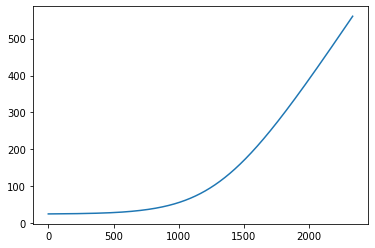

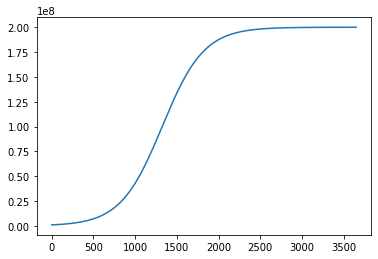

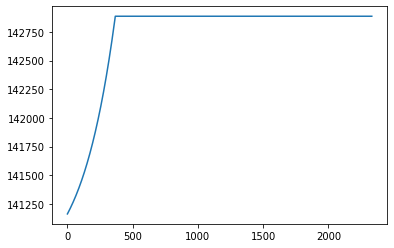

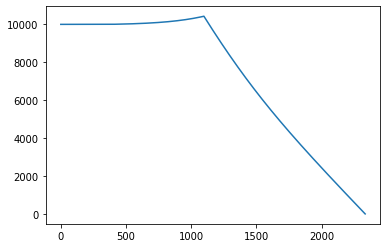

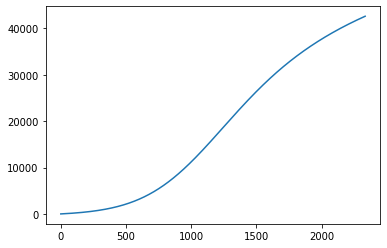

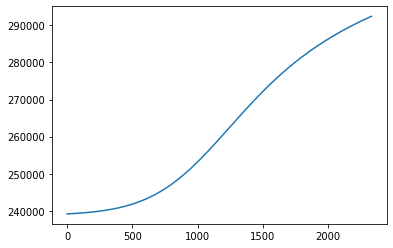

4235940.292487947 199981766.03075913 25000


In [262]:
#staking_apr_timeseries = 

#plt.plot(np.pad(rook_price_timeseries, (0,len(daily_volume_usd_timeseries)-len(rook_price_timeseries)), 'constant', constant_values=rook_price_timeseries[-1]))
plt.plot(rook_price_timeseries)
plt.show()

plt.plot(daily_volume_usd_timeseries)
plt.show()

#plt.plot(np.pad(treasury_rook_timeseries, (0,len(daily_volume_usd_timeseries)-len(treasury_rook_timeseries)), 'constant', constant_values=treasury_rook_timeseries[-1]))
plt.plot(treasury_rook_timeseries)
plt.show()

plt.plot(treasury_eth_timeseries)
plt.show()

plt.plot(burned_rook_timeseries)
plt.show()

plt.plot(staked_rook_timeseries)
plt.show()


print(daily_volume_usd_timeseries[365], daily_volume_usd_timeseries[-1], treasury_burn_rate)

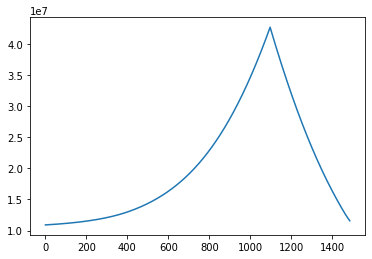

In [203]:
mcap_timeseries = circ_supply_timeseries * rook_price_timeseries
plt.plot(mcap_timeseries)
plt.show()